In [30]:
import zarr
from scipy.spatial.distance import squareform
import numpy as np
import anjl
import pandas as pd
import plotly.express as px
import sys
import time
from contextlib import contextmanager
from tqdm.auto import tqdm


@contextmanager
def section(*msg):
    print(*msg, file=sys.stdout, end="... ")
    sys.stdout.flush()
    before = time.time()
    try:
        yield
    finally:
        after = time.time()
        duration = after - before
        print(f"{duration:.4f}s", file=sys.stdout)
        sys.stdout.flush()


def run_diagnostics(D, template="plotly"):
    with section("canonical"):
        _, timings_canonical, searched_canonical, visited_canonical = anjl.canonical_nj(
            D,
            diagnostics=True,
        )

    with section("rapid_gc100"):
        _, timings_rapid_gc100, searched_rapid_gc100, visited_rapid_gc100 = (
            anjl.rapid_nj(
                D,
                diagnostics=True,
                gc=100,
            )
        )

    with section("rapid_gc10"):
        _, timings_rapid_gc10, searched_rapid_gc10, visited_rapid_gc10 = anjl.rapid_nj(
            D,
            diagnostics=True,
            gc=10,
        )

    with section("rapid_nogc"):
        _, timings_rapid_nogc, searched_rapid_nogc, visited_rapid_nogc = anjl.rapid_nj(
            D,
            diagnostics=True,
            gc=None,
        )

    df_canonical = pd.DataFrame(
        {
            "time": timings_canonical,
            "searched": searched_canonical,
            "visited": visited_canonical,
            "iteration": np.arange(len(timings_canonical)),
            "algorithm": "canonical",
        }
    )
    df_rapid_gc100 = pd.DataFrame(
        {
            "time": timings_rapid_gc100,
            "searched": searched_rapid_gc100,
            "visited": visited_rapid_gc100,
            "iteration": np.arange(len(timings_rapid_gc100)),
            "algorithm": "rapid_gc100",
        }
    )
    df_rapid_gc10 = pd.DataFrame(
        {
            "time": timings_rapid_gc10,
            "searched": searched_rapid_gc10,
            "visited": visited_rapid_gc10,
            "iteration": np.arange(len(timings_rapid_gc10)),
            "algorithm": "rapid_gc10",
        }
    )
    df_rapid_nogc = pd.DataFrame(
        {
            "time": timings_rapid_nogc,
            "searched": searched_rapid_nogc,
            "visited": visited_rapid_nogc,
            "iteration": np.arange(len(timings_rapid_nogc)),
            "algorithm": "rapid_nogc",
        }
    )

    df_diagnostics = pd.concat(
        [
            df_rapid_gc100,
            df_rapid_gc10,
            df_rapid_nogc,
            df_canonical,
        ],
        axis=0,
    )
    df_diagnostics["time_per_search"] = df_diagnostics.eval("time / searched")
    df_diagnostics["time_per_visit"] = df_diagnostics.eval("time / visited")
    display(
        df_diagnostics.groupby("algorithm").agg(
            {
                "time": "sum",
                "visited": "sum",
                "searched": "sum",
                "time_per_visit": "median",
                "time_per_search": "median",
            }
        )
    )

    fig = px.line(
        df_diagnostics,
        x="iteration",
        y="time",
        color="algorithm",
        template=template,
        render_mode="svg",
    )
    fig.update_xaxes(range=[0, None])
    fig.show()

    fig = px.line(
        df_diagnostics,
        x="iteration",
        y="searched",
        color="algorithm",
        template=template,
        render_mode="svg",
    )
    fig.update_xaxes(range=[0, None])
    fig.show()

    fig = px.line(
        df_diagnostics,
        x="iteration",
        y="visited",
        color="algorithm",
        template=template,
        render_mode="svg",
    )
    fig.update_xaxes(range=[0, None])
    fig.show()

    fig = px.line(
        df_diagnostics,
        x="iteration",
        y="time_per_search",
        color="algorithm",
        template=template,
        render_mode="svg",
    )
    fig.update_xaxes(range=[0, None])
    fig.show()

    fig = px.line(
        df_diagnostics,
        x="iteration",
        y="time_per_visit",
        color="algorithm",
        template=template,
        render_mode="svg",
    )
    fig.update_xaxes(range=[0, None])
    fig.show()

## Small

In [2]:
small = zarr.load("../data/small/dist.zarr.zip")
small_D = squareform(small)
small_D.shape

(181, 181)

In [3]:
small_Z = anjl.canonical_nj(small_D)

In [4]:
small_Z_r = anjl.rapid_nj(small_D, gc=None)

In [5]:
small_Z_r = anjl.rapid_nj(small_D, gc=1)

In [6]:
%%timeit -r100 -n1
anjl.canonical_nj(small_D)

2.12 ms ± 372 μs per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [7]:
%%timeit -r100 -n1
anjl.rapid_nj(small_D, gc=None)

6.39 ms ± 1.49 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [8]:
%%timeit -r100 -n1
anjl.rapid_nj(small_D, gc=100)

5.27 ms ± 437 μs per loop (mean ± std. dev. of 100 runs, 1 loop each)


canonical... 0.0032s
rapid_gc100... 0.0063s
rapid_gc10... 0.0073s
rapid_nogc... 0.0072s


time  visited  searched  time_per_visit  time_per_search
algorithm                                                                
canonical    0.002352  1387792    988259    1.539638e-09     2.836232e-09
rapid_gc10   0.004777   360062    323387    1.231446e-08     1.378460e-08
rapid_gc100  0.004830   446886    323381    1.074611e-08     1.500977e-08
rapid_nogc   0.005745   488963    323381    1.132907e-08     2.175516e-08

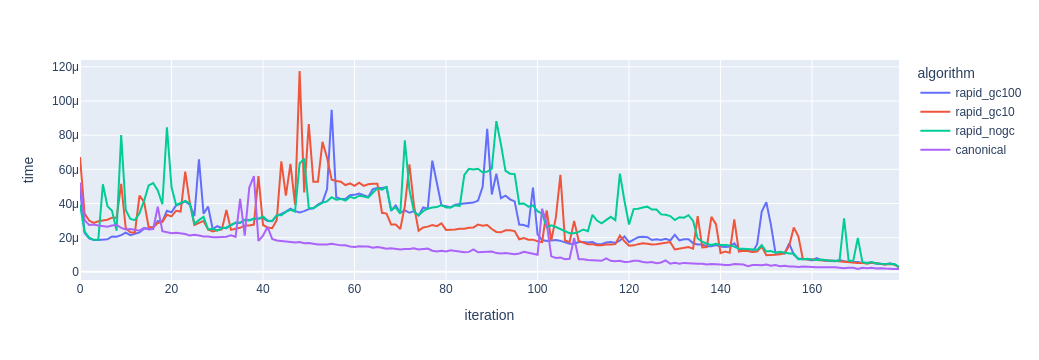

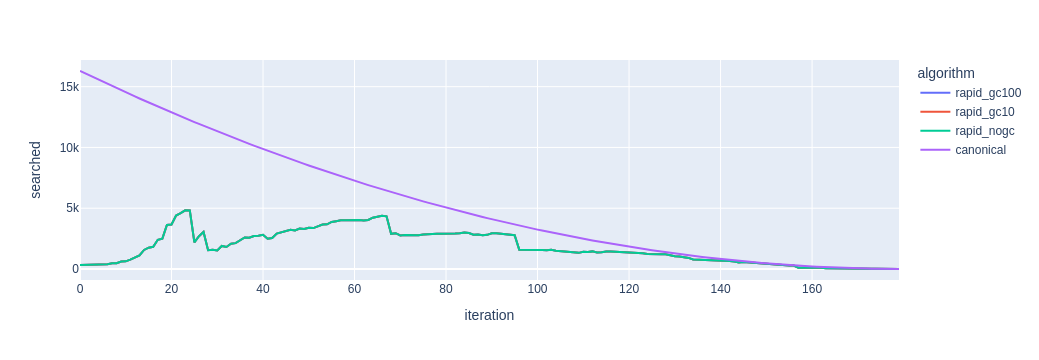

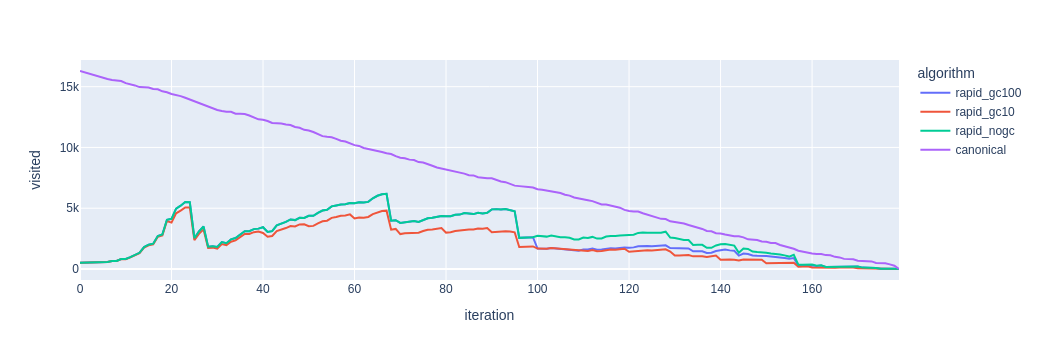

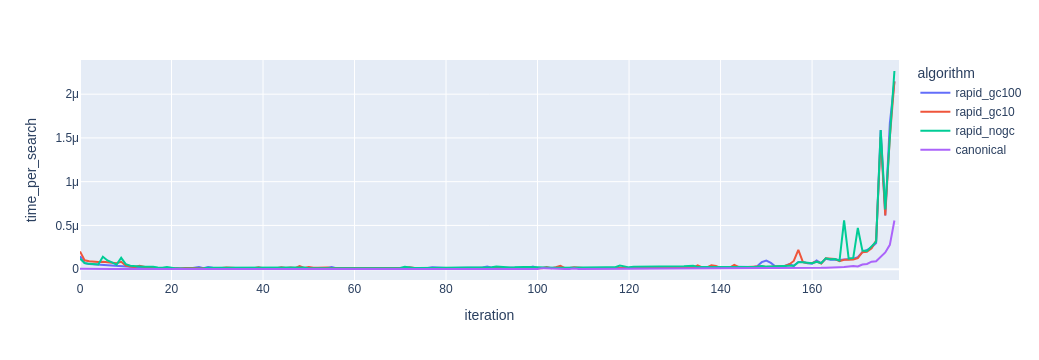

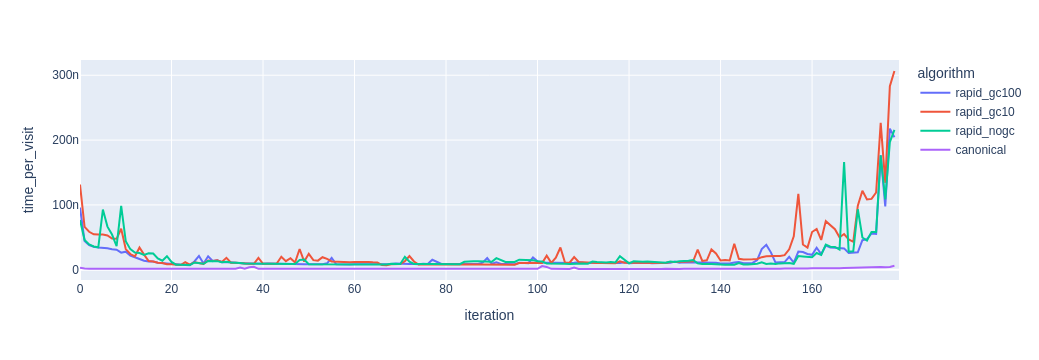

In [9]:
run_diagnostics(small_D)

## Medium

In [10]:
medium = zarr.load("../data/medium/dist.zarr.zip")
medium_D = squareform(medium)
medium_D.shape

(472, 472)

In [11]:
%%time
medium_Z = anjl.canonical_nj(medium_D)

CPU times: user 43 ms, sys: 977 μs, total: 44 ms
Wall time: 42.4 ms


In [12]:
%%time
medium_Z_r = anjl.rapid_nj(medium_D)

CPU times: user 52.2 ms, sys: 3.93 ms, total: 56.1 ms
Wall time: 54.8 ms


In [13]:
%%timeit -r50 -n1
anjl.canonical_nj(medium_D)

28.1 ms ± 1.9 ms per loop (mean ± std. dev. of 50 runs, 1 loop each)


In [14]:
%%timeit -r30 -n1
anjl.rapid_nj(medium_D, gc=None)

60.6 ms ± 2.93 ms per loop (mean ± std. dev. of 30 runs, 1 loop each)


In [15]:
%%timeit -r30 -n1
anjl.rapid_nj(medium_D, gc=10)

41.2 ms ± 2.48 ms per loop (mean ± std. dev. of 30 runs, 1 loop each)


In [16]:
%%timeit -r30 -n1
anjl.rapid_nj(medium_D, gc=100)

45.2 ms ± 2.12 ms per loop (mean ± std. dev. of 30 runs, 1 loop each)


In [17]:
%%timeit -r20 -n1
anjl.rapid_nj(medium_D, gc=1)

83.6 ms ± 3.36 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)


canonical... 0.0332s
rapid_gc100... 0.0495s
rapid_gc10... 0.0458s
rapid_nogc... 0.0652s


time   visited  searched  time_per_visit  time_per_search
algorithm                                                                 
canonical    0.032315  24578030  17525595    1.031384e-09     1.967741e-09
rapid_gc10   0.032346   3971729   3726983    8.750208e-09     9.477045e-09
rapid_gc100  0.041932   4941507   3726983    9.095514e-09     1.353269e-08
rapid_nogc   0.059662   6985714   3726983    8.109516e-09     1.802316e-08

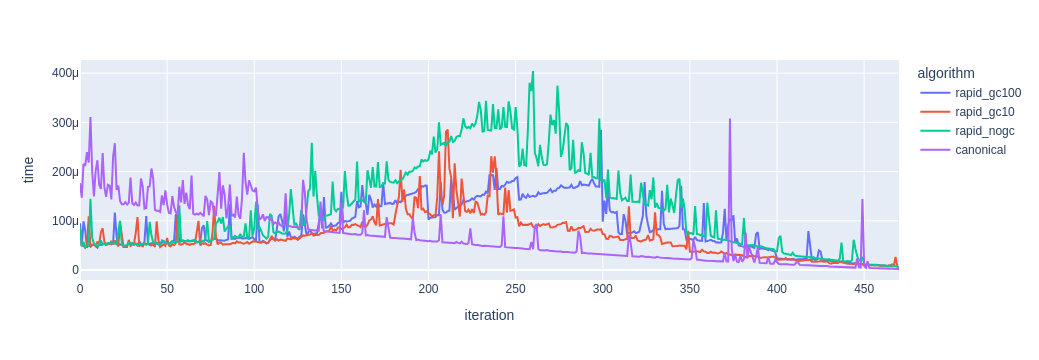

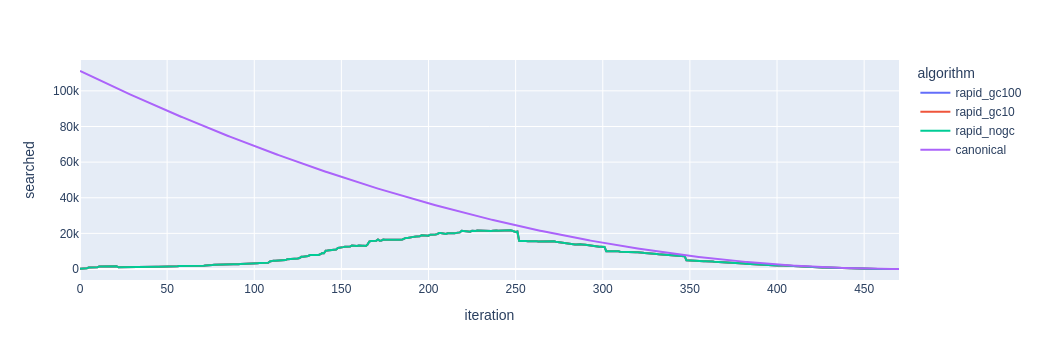

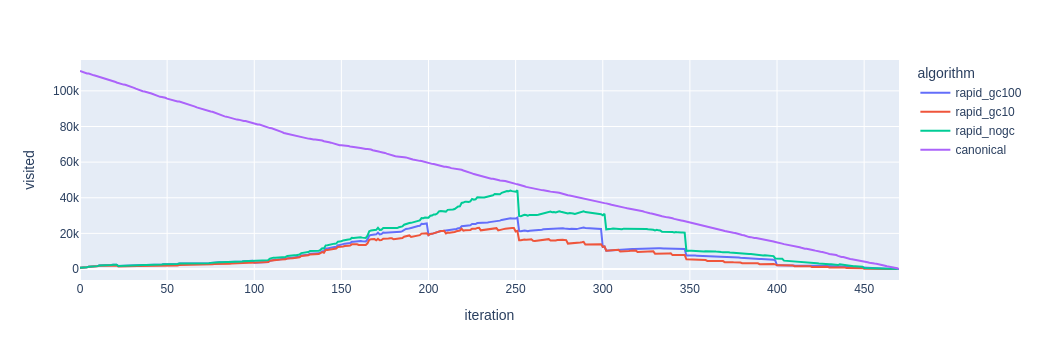

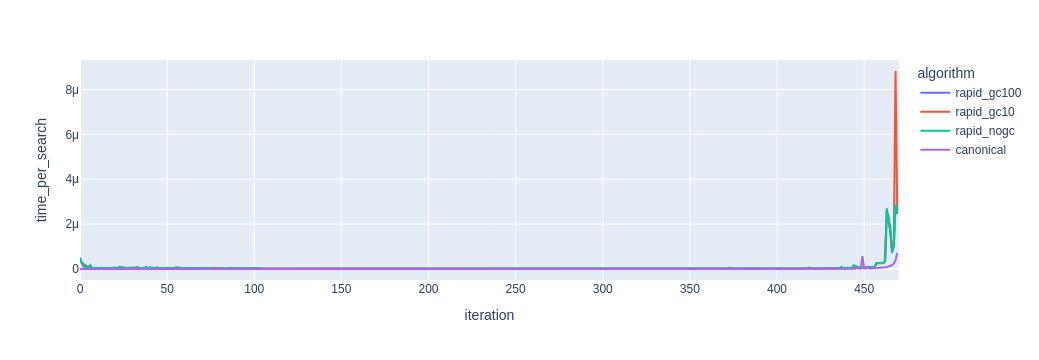

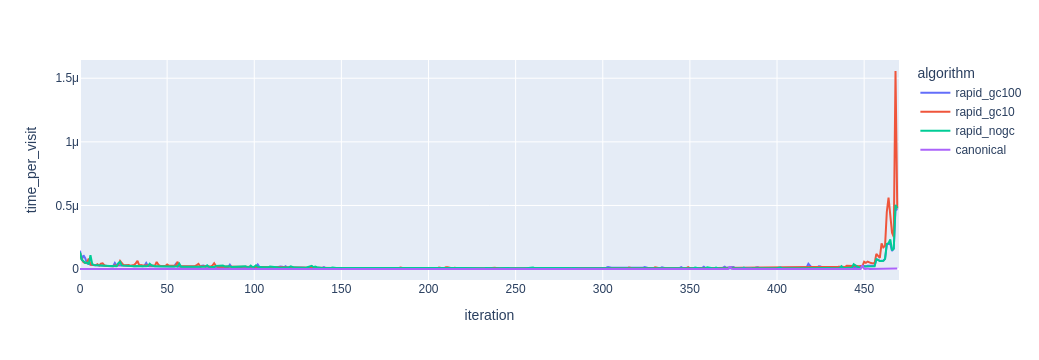

In [18]:
run_diagnostics(medium_D)

In [ ]:
# %%profila
# anjl.canonical_nj(medium_D)

In [ ]:
# %%profila
# anjl.rapid_nj(medium_D, gc=100)

## Large

canonical... 2.0246s
rapid_gc100... 2.3911s
rapid_gc10... 2.4006s
rapid_nogc... 3.1049s


time     visited    searched  time_per_visit  time_per_search
algorithm                                                                     
canonical    2.015190  1937166008  1333332999    8.902228e-10     1.631695e-09
rapid_gc10   1.869270   274160822   270368297    6.896921e-09     7.031373e-09
rapid_gc100  2.232113   289976509   270368317    7.655940e-09     8.652302e-09
rapid_nogc   3.028607   389796679   270368292    7.766014e-09     1.204786e-08

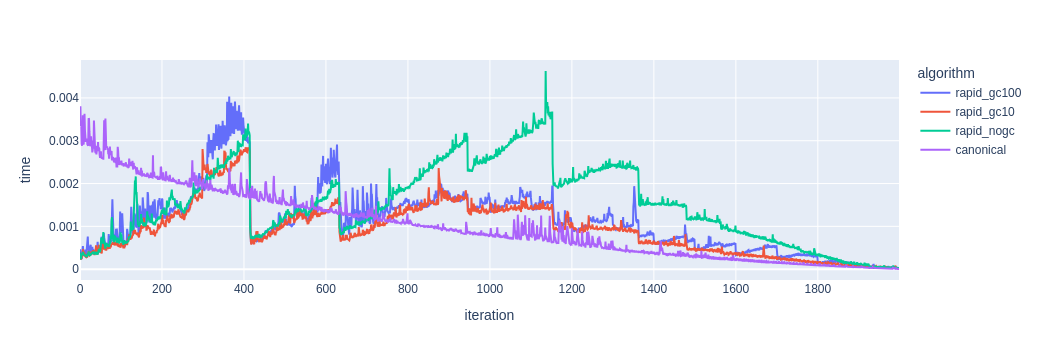

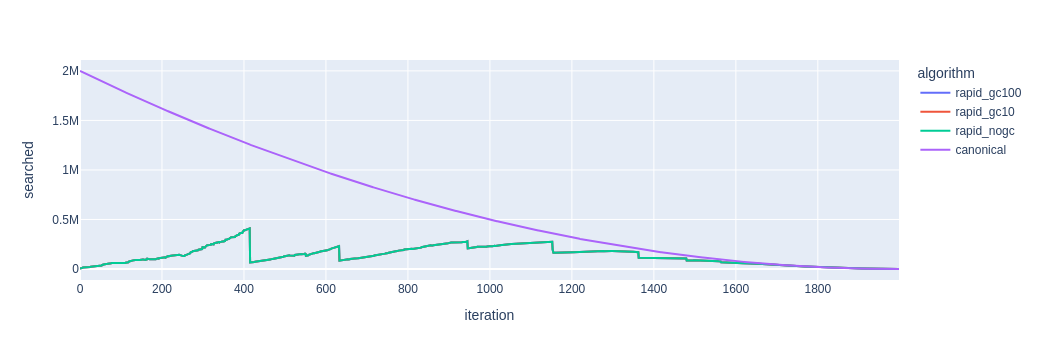

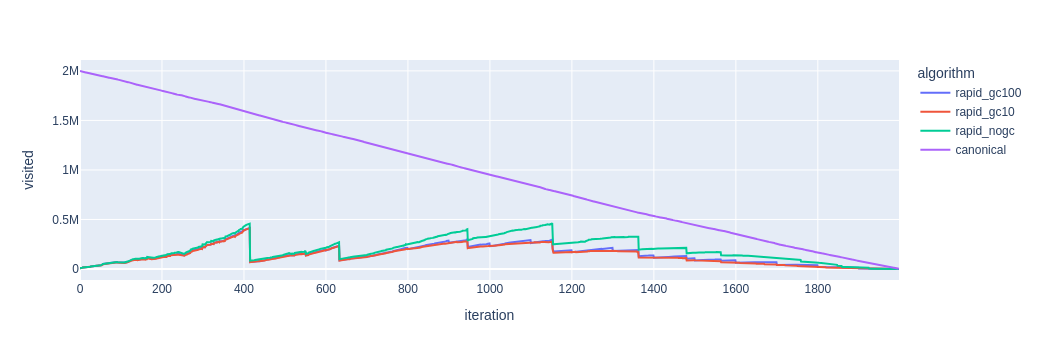

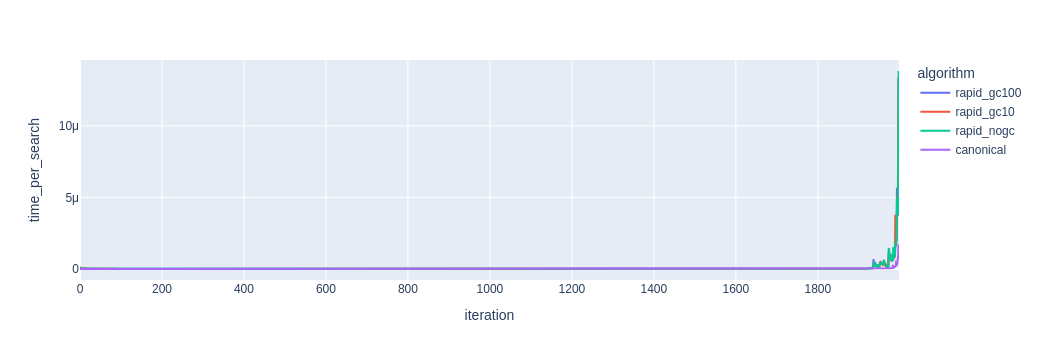

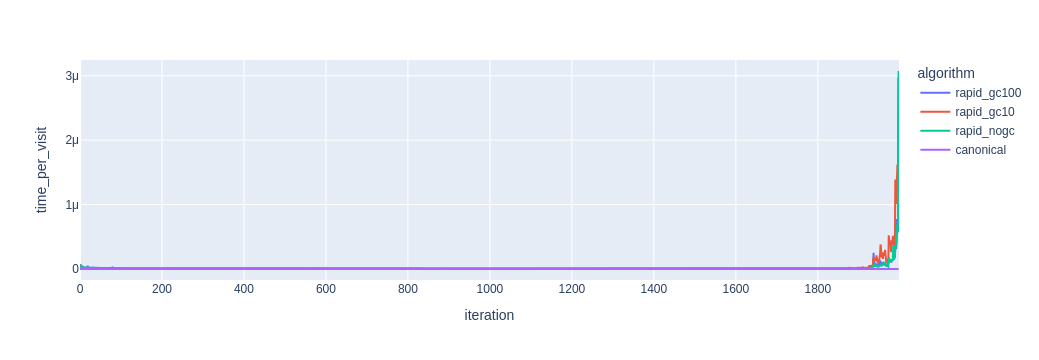

In [20]:
large = zarr.load("../data/large/dist.zarr.zip")
large_D = squareform(large)
shuffle = np.random.choice(large_D.shape[0], size=2000, replace=False)
large_D_shuffled = large_D.take(shuffle, axis=0).take(shuffle, axis=1)
run_diagnostics(large_D_shuffled)

In [ ]:
# %%profila
# large_Z = anjl.canonical_nj(large_D_shuffled)

# %%profila
# large_Z = anjl.rapid_nj(large_D_shuffled, gc=100)

In [21]:
%%timeit -r5 -n1
anjl.canonical_nj(large_D_shuffled)

1.96 s ± 66.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [22]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=10)

2.67 s ± 265 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [23]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=100)

2.43 s ± 210 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [24]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=200)

2.25 s ± 32.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [25]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=None)

3.45 s ± 62.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [26]:
%%timeit -r3 -n1
np.argsort(large_D_shuffled, axis=1)

70 ms ± 5.72 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## XL

In [28]:
xxl = zarr.load("../data/xxl/dist.zarr.zip")
xxl_D = squareform(xxl)
xxl_shuffle = np.random.choice(xxl_D.shape[0], size=5000, replace=False)
xxl_D_shuffled = xxl_D.take(xxl_shuffle, axis=0).take(xxl_shuffle, axis=1)
# run_diagnostics(xxl_D_shuffled)

In [31]:
anjl.canonical_nj(xxl_D_shuffled, progress=tqdm)

  0%|          | 0/4999 [00:00<?, ?it/s]

array([[8.2900000e+02, 2.3410000e+03, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00],
       [3.2470000e+03, 5.0000000e+03, 0.0000000e+00, 0.0000000e+00,
        3.0000000e+00],
       [6.5000000e+01, 4.8100000e+02, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00],
       ...,
       [9.9940000e+03, 9.9950000e+03, 4.9504809e-02, 2.2650726e-02,
        1.7110000e+03],
       [9.9870000e+03, 9.9960000e+03, 1.2213695e-01, 1.9955546e-02,
        4.7980000e+03],
       [9.9780000e+03, 9.9970000e+03, 9.4669722e-02, 9.4669722e-02,
        5.0000000e+03]], dtype=float32)

In [32]:
anjl.rapid_nj(xxl_D_shuffled, gc=100, progress=tqdm)

  0%|          | 0/4999 [00:00<?, ?it/s]

array([[8.2900000e+02, 3.2470000e+03, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00],
       [2.3410000e+03, 5.0000000e+03, 0.0000000e+00, 0.0000000e+00,
        3.0000000e+00],
       [6.5000000e+01, 4.8100000e+02, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00],
       ...,
       [9.9940000e+03, 9.9950000e+03, 4.9504809e-02, 2.2650726e-02,
        1.7110000e+03],
       [9.9870000e+03, 9.9960000e+03, 1.2213695e-01, 1.9955546e-02,
        4.7980000e+03],
       [9.9780000e+03, 9.9970000e+03, 9.4669722e-02, 9.4669722e-02,
        5.0000000e+03]], dtype=float32)